<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/EIT_absorptionCoeff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

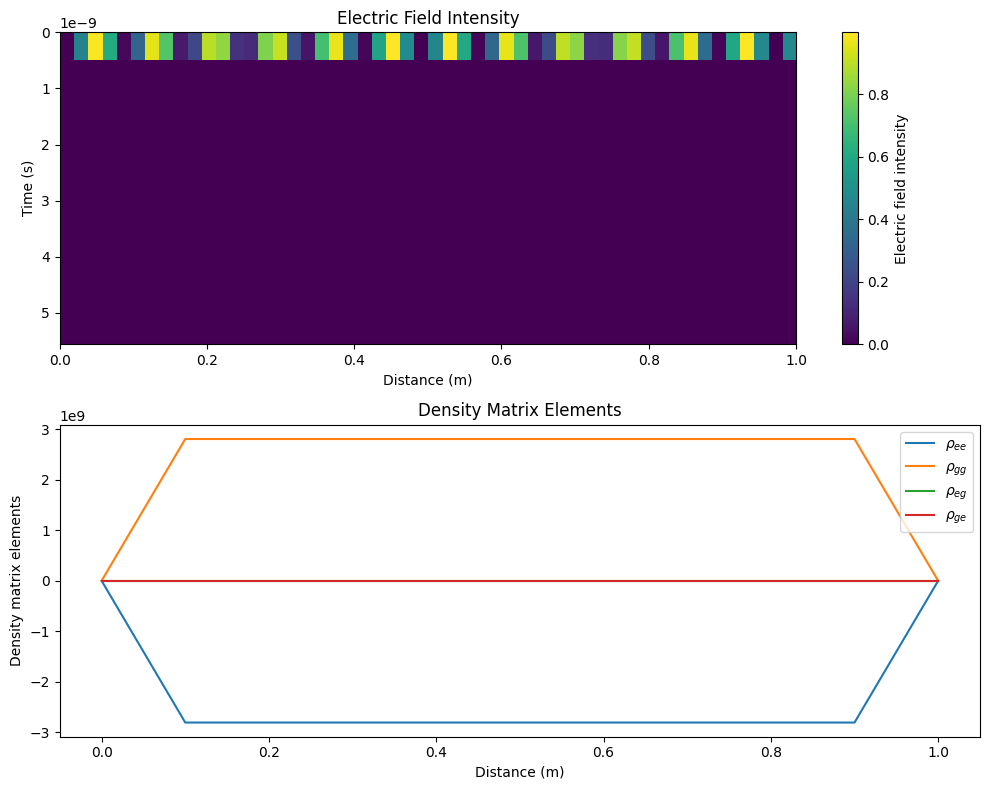

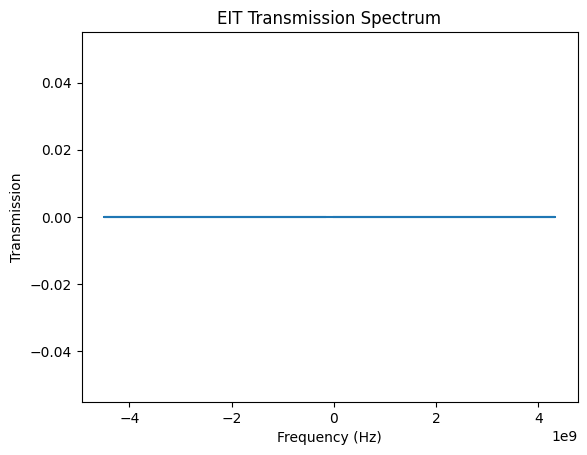

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants and parameters
c = 299792458  # speed of light in vacuum
n = 1.5  # refractive index of medium 1.5
epsilon_0 = 8.85418782e-12  # vacuum permittivity

# Define grid parameters
dz = 0.1  # spatial step size
dt = dz / (2 * c * n)  # time step size
z_max = 1  # maximum simulation distance
t_max = 50 * dt  # maximum simulation time
z = np.arange(0, z_max + dz, dz)  # spatial grid
t = np.arange(0, t_max + dt, dt)  # time grid
nz = len(z)
nt = len(t)

# Control field equation
def electric_field(t, t0, omega_p, omega_s):
    return np.sin(omega_p * (t - t0)) * np.exp(-(omega_p - omega_s) ** 2 * (t - t0) ** 2 / 2)

# Define initial conditions
E = np.zeros((nz, nt), dtype=complex)
P = np.zeros((nz, nt), dtype=complex)

# Atomic system parameters
gamma = 3.8e-3  # decay rate (Hz) 1e7
omega_c = 2.5 * np.pi * 1e9  # control field angular frequency (rad/s) 1e9
delta = 0  # detuning (Hz) 0

# Control field parameters
t0 = 50 * dt  # center of the control field pulse
omega_p = 6.834 * np.pi * 1e9  # probe field angular frequency (rad/s)
omega_s = 6.834 * np.pi * 1e9  # control field angular frequency (rad/s)

# Create control field
Ec = np.array([electric_field(time, t0, omega_p, omega_s) for time in t])

# Three-level system
rho_ee = np.zeros((nz, nt), dtype=complex)
rho_eg = np.zeros((nz, nt), dtype=complex)
rho_ge = np.zeros((nz, nt), dtype=complex)
rho_gg = np.ones((nz, nt), dtype=complex)

# FDTD loop over time steps
for i in range(1, nt):
    # Update electric field
    E[1:-1, i] = E[1:-1, i - 1] + (c * dt / n) * (P[2:, i - 1] - P[1:-1, i - 1]) / dz
    E[0, i] = Ec[i]  # Modify input boundary condition with the control field
    E[-1, i] = 0

    # Update polarization density
    P[1:-1, i] = P[1:-1, i - 1] + (epsilon_0 * dt) * (E[1:-1, i] - E[1:-1, i - 1])

    # Update density matrix elements
    rho_ee[1:-1, i] = rho_ee[1:-1, i - 1] + dt * (-gamma * rho_ee[1:-1, i - 1] + 1j * omega_c * (rho_ge[1:-1, i - 1] - rho_eg[1:-1, i - 1]))
    rho_gg[1:-1, i] = 1 - rho_ee[1:-1, i]
    rho_eg[1:-1, i] = rho_eg[1:-1, i - 1] + dt * (1j * delta * rho_eg[1:-1, i - 1] - gamma * rho_eg[1:-1, i - 1] / 2 - 1j * E[1:-1, i] * rho_ee[1:-1, i] + 1j * omega_c * rho_gg[1:-1, i - 1])
    rho_ge[1:-1, i] = np.conj(rho_eg[1:-1, i])

    # Update polarization density with EIT term
    P[1:-1, i] = epsilon_0 * rho_eg[1:-1, i]


    # Update density matrix elements
rho_ee[1:-1, i] = rho_ee[1:-1, i - 1] + dt * (-gamma * rho_ee[1:-1, i - 1] + 1j * omega_c * (rho_ge[1:-1, i - 1] - rho_eg[1:-1, i - 1]))
rho_gg[1:-1, i] = 1 - rho_ee[1:-1, i]
rho_eg[1:-1, i] = rho_eg[1:-1, i - 1] + dt * (1j * delta * rho_eg[1:-1, i - 1] - gamma * rho_eg[1:-1, i - 1] / 2 - 1j * E[1:-1, i] * rho_ee[1:-1, i] + 1j * omega_c * rho_gg[1:-1, i - 1])
rho_ge[1:-1, i] = np.conj(rho_eg[1:-1, i])

# Update polarization density with EIT term
P[1:-1, i] = epsilon_0 * rho_eg[1:-1, i]

# Plot results
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.imshow(np.abs(E)**2, extent=[0, z_max, t_max, 0], aspect='auto')
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.colorbar(label='Electric field intensity')
plt.title('Electric Field Intensity')

# Plot density matrix elements
plt.subplot(212)
plt.plot(z, np.real(rho_ee[:, -1]), label='$\\rho_{ee}$')
plt.plot(z, np.real(rho_gg[:, -1]), label='$\\rho_{gg}$')
plt.plot(z, np.real(rho_eg[:, -1]), label='$\\rho_{eg}$')
plt.plot(z, np.real(rho_ge[:, -1]), label='$\\rho_{ge}$')
plt.xlabel('Distance (m)')
plt.ylabel('Density matrix elements')
plt.legend()
plt.title('Density Matrix Elements')

plt.tight_layout()
plt.show()


# Calculate transmission spectrum
E_input = np.fft.fft(E[0, :])
E_output = np.fft.fft(E[-1, :])
transmission = np.abs(E_output / E_input)

# Plot transmission spectrum
frequencies = np.fft.fftfreq(nt, dt)
plt.plot(frequencies, transmission)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Transmission')
plt.title('EIT Transmission Spectrum')
plt.show()
